# Warp factory for Python

This code represents the outcome of an exploration I conducted on how to compute the stress-energy tensor for a given spacetime metric. My goal is to replicate the functionality of the "Warp Factory" code described in the paper arXiv:2404.03095.

In contrast to the approach in that study, I aim to leverage the full capabilities of SymPy and EinsteinPy to derive analytical expressions for various quantities of interest, avoiding reliance on numerical approximations whenever possible. This symbolic approach allows for greater flexibility and precision in theoretical investigations.

I may introduce additional constraints on the physicality of the energy-momentum tensor, particularly when negative energy arises, as discussed in arXiv
/9702026.

At this stage, the code is more of a collection of potential applications without a clear overarching theme or direction.

### import relevant library

In [1]:
import sympy as sp
from einsteinpy.symbolic import MetricTensor, ChristoffelSymbols, RiemannCurvatureTensor, RicciTensor, RicciScalar, EinsteinTensor
from sympy import init_printing

import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

## Operating System

### Functions

In [2]:
def christoffel_x_vector(V,metric_einsteinpy,sp_symbols, vector_is_covariant):
    # The given metric must be a einsteinpy object not a tensor!

    dim=len(sp_symbols)

    # Compute Christoffel Symbols for the given metric
    ch_sym = ChristoffelSymbols.from_metric(metric_einsteinpy)
    
    # Christoffel symbol array (with lower indices)
    T_uv_h = ch_sym.tensor()



    if vector_is_covariant:
        # Initialize matrices A and B
        A_uv = sp.zeros(dim, dim)  # A_{uv} matrix (4x4)
        
        # Perform the matrix multiplication for A_uv = T_{uv}^h * V_h
        for u in range(dim):
            for v in range(dim):
                A_uv[u, v] = sum(T_uv_h[h,u,v] * V[h] for h in range(dim)) #first index is the upper index for christoffel symbol


        return A_uv
        
    else:
        # Initialize matrices A and B
        B_u_v = sp.zeros(dim, dim)  # B_u^v matrix (4x4)
        
        
        # Perform the matrix multiplication for B_u^v = T_{uh}^v * V^h
        for u in range(dim):
            for v in range(dim):
                B_u_v[u, v] = sum(T_uv_h[v,u,h]  * V[h] for h in range(dim))

        return B_u_v




In [3]:
def covariant_derivative(V,metric_einsteinpy,sp_symbols, vector_is_covariant):

    dim=len(sp_symbols)

    #Initialize an empty matrix for partial derivatives
    partial_matrix = sp.Matrix.zeros(dim,dim)
    
    #Compute the partial derivatives for all combinations
    for i in range(dim):  # iterate over coordinates u^i
        for j in range(dim):  # iterate over vector components V^v
            partial_matrix[i, j] = sp.diff(V[j], sp_symbols[i])
    

    
    ch_V=christoffel_x_vector(V,metric_einsteinpy,sp_symbols, vector_is_covariant)


    if vector_is_covariant:

        return partial_matrix-ch_V

    else:

        return partial_matrix+ch_V


    
    

In [4]:
def get_tetrahed(user_input_metric):
    #The tetrahed is defined as in https://arxiv.org/abs/2404.03095

    g = sp.symbols('g1:11')
 
    # Define the scalars A, B, C, and D
    # Define the scalars with adjusted indices
    A = g[9]
    
    B = -g[8]**2 + g[7] * g[9]
    
    C = (-g[4] * g[8]**2 - g[7] * g[6]**2 - g[9] * g[5]**2
         + 2 * g[5] * g[6] * g[8] + g[4] * g[7] * g[9])
    
    
    D = (g[1]**2 * g[8]**2 + g[2]**2 * g[6]**2 + g[3]**2 * g[5]**2
         - g[7] * g[9] * g[1]**2 - g[4] * g[9] * g[2]**2 - g[4] * g[7] * g[3]**2
         - g[0] * g[9] * g[5]**2 - g[0] * g[7] * g[6]**2 - g[0] * g[4] * g[8]**2
         + 2 * g[9] * g[1] * g[2] * g[5] + 2 * g[7] * g[1] * g[3] * g[6]
         + 2 * g[4] * g[2] * g[3] * g[8] + 2 * g[0] * g[5] * g[6] * g[8] 
         - 2 * g[1] * g[2] * g[6] * g[8] - 2 * g[1] * g[3] * g[5] * g[8]
         - 2 * g[2] * g[3] * g[5] * g[6] + g[0] * g[4] * g[7] * g[9])
    
    
    #note : (A,B,C,D) = (-,+,+,+)
    
    E_0 =(1 / sp.sqrt(-C * D)) * sp.Matrix([
        C,   #here, first error of the paper, it's a +C not -C             
         
         g[1] * g[8]**2 + g[2] * g[5] * g[9] + g[3] * g[6] * g[7] - g[1] * g[7] * g[9] - g[2] * g[6] * g[8] - g[3] * g[5] * g[8],
    
        g[2] * g[6]**2 + g[1] * g[5] * g[9] + g[3] * g[4] * g[8] - g[1] * g[6] * g[8] - g[2] * g[4] * g[9] - g[3] * g[5] * g[6],
    
        g[3] * g[5]**2 + g[1] * g[6] * g[7] + g[2] * g[4] * g[8] - g[1] * g[5] * g[8] - g[2] * g[5] * g[6] - g[3] * g[4] * g[7]
    
    ])
    
    E_1=(1 / sp.sqrt(B*C)) * sp.Matrix([
        0,                
         
        B,
    
        #g[5] * g[9] - g[6] * g[8], second error in the paper
        -g[5] * g[9] + g[6] * g[8],
    
        g[5] * g[8] - g[6] * g[7]
    
    ])
    
    E_2=(1 / sp.sqrt(A*B)) * sp.Matrix([
        0,                
         
        0,
    
        A,
    
        -g[8] 
    
    ])
    
    E_3=(1 / sp.sqrt(A)) * sp.Matrix([
        0,                
         
        0,
    
        0,
    
        1
    
    ])
    
    E_solution=matrix = sp.Matrix.hstack(E_0, E_1, E_2, E_3)
    
    
    
    E_0=sp.simplify(E_0.subs(user_input_metric))
    E_1=sp.simplify(E_1.subs(user_input_metric))
    E_2=sp.simplify(E_2.subs(user_input_metric))
    E_3=sp.simplify(E_3.subs(user_input_metric))
    
    E_solution=sp.simplify(E_solution.subs(user_input_metric))

    return E_0, E_1, E_2, E_3, E_solution
        

### Class

In [5]:
class Warp_drive:
    def __init__(self, sp_symbols, function_substitutions, metric_from_user_input):
        """
        Initializes a new Warp_drive object.
        
        :sp_symbols: List of symbols to represent spacetime coordinate.
        
        :function_substitutions. Dictionnary of sympy functions
            example: {f:f_actual,v:v_actual}
            f and v are the symbolic function depending on spacetime coordinates and f_actual 
            and v_actual are the actual functions expression.
            
        :metric_from_user_input: Dictionnary associating g1,g2,...,g9 the symbol of the metric 
        to the desired metric.
        
        """
        g = sp.symbols('g1:11')
        
        metric_from_user_input_ = {
            g[0]: metric_from_user_input["g1"],
            g[1]: metric_from_user_input["g2"],
            g[2]: metric_from_user_input["g3"],
            g[3]: metric_from_user_input["g4"],
            g[4]: metric_from_user_input["g5"],
            g[5]: metric_from_user_input["g6"],
            g[6]: metric_from_user_input["g7"],
            g[7]: metric_from_user_input["g8"],
            g[8]: metric_from_user_input["g9"],
            g[9]: metric_from_user_input["g10"]   
        }


        
        self.symbols = sp_symbols
        self.f_subs = function_substitutions
        self.user_input_metric = metric_from_user_input_

        self.Is_built=False

        gravity_const=6.6743*1e-11
        c_speed_const=299792458
        pi_8=8*np.pi
        self.physical_energy_conversion=c_speed_const**4/pi_8/gravity_const
        self.physical_momentum_conversion=self.physical_energy_conversion/c_speed_const



    def build_and_compute(self):
       
    
        #Construct the template on which we are going to substitute user inputs
        g = sp.symbols('g1:11')
        metric_template = sp.Matrix([
            [g[0], g[1], g[2], g[3]],
            [g[1], g[4], g[5], g[6]],
            [g[2], g[5], g[7], g[8]],
            [g[3], g[6], g[8], g[9]]
        ])
    
        
    
        # Update the template
        Metric = metric_template.subs(self.user_input_metric)
        
        # Create a MetricTensor object that can be used with einsteinpy
        m_obj = MetricTensor(sp.Array(Metric), self.symbols)
    
        #no need to compute the following quantity but they are available at this point
        
        # Compute Christoffel symbols
        #ch = ChristoffelSymbols.from_metric(m_obj)
        
        # Compute Riemann Curvature Tensor
        #riemann = RiemannCurvatureTensor.from_christoffels(ch)
        
        # Compute Ricci Tensor
        #ricci = RicciTensor.from_riemann(riemann)
        
        # Compute Ricci Scalar
        #ricci_scalar = RicciScalar.from_riccitensor(ricci)
        
        # Compute EinsteinTensor
        einst = EinsteinTensor.from_metric(m_obj)
        #we go back to sympy object
        Einstein_tensor=einst.tensor() 
        Tuv=sp.simplify(sp.Matrix(Einstein_tensor)) #mind that the unit are not yet correct
    
        self.Metric=Metric
        self.Tuv=Tuv
    
        print("Einstein tensor computed.")#############################################################################
    
    
        #Get tetrahed
        E_0, E_1, E_2, E_3, E_solution = get_tetrahed(self.user_input_metric)
    
        # The tetrahed corresponding to the local observer whose 4-velocity vector is orthogonal 
        # to constant time hypersurface. 
    
        print("Tetrahed computed.")####################################################################################
        
    
        #compute Tu^v^, the energy-momentum tensor from the perspective of a local observer 
        Tuv_ref=sp.simplify((E_solution.T)*Tuv*E_solution)
    
        self.Tuv_ref=Tuv_ref
        
        #NEC ====================================================================
        
        # Define symbolic variables theta and psi
        self.theta, self.psi = sp.symbols('theta psi')
        
        # Define the parametric null-vector (1, sin(theta)*cos(psi), sin(theta)*sin(psi), cos(theta)) 
        ku = sp.Matrix([
            1,
            sp.sin(self.theta) * sp.cos(self.psi),
            sp.sin(self.theta) * sp.sin(self.psi),
            sp.cos(self.theta)
        ])
        
        NEC=ku.T*Tuv_ref*ku
        NEC=NEC[0,0] #conversion from matrix (1,1) to scalar
    
        self.NEC=NEC
        
        #WEC ====================================================================
        
        # Define the rapidities
        self.eta_1, self.eta_2, self.eta_3 = sp.symbols('eta_1 eta_2 eta_3')
        
        # Define the hyperbolic functions
        cosh_1, sinh_1 = sp.cosh(self.eta_1), sp.sinh(self.eta_1)
        cosh_2, sinh_2 = sp.cosh(self.eta_2), sp.sinh(self.eta_2)
        cosh_3, sinh_3 = sp.cosh(self.eta_3), sp.sinh(self.eta_3)
        
        # Lorentz boost in the x-direction (eta_1)
        Lambda_1 = sp.Matrix([
            [cosh_1, -sinh_1, 0, 0],
            [-sinh_1, cosh_1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])
        
        # Lorentz boost in the y-direction (eta_2)
        Lambda_2 = sp.Matrix([
            [cosh_2, 0, -sinh_2, 0],
            [0, 1, 0, 0],
            [-sinh_2, 0, cosh_2, 0],
            [0, 0, 0, 1]
        ])
        
        # Lorentz boost in the z-direction (eta_3)
        Lambda_3 = sp.Matrix([
            [cosh_3, 0, 0, -sinh_3],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [-sinh_3, 0, 0, cosh_3]
        ])
        
        # Define the parametric time-vector
        Uu=sp.Matrix([1,0,0,0])
        Uu=Lambda_1*Lambda_2*Lambda_3*Uu
        
        WEC=Uu.T*Tuv_ref*Uu
        WEC=WEC[0,0]
    
        self.WEC=WEC
        
        #SEC ====================================================================
        minkowski=sp.Matrix([
            [-1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])
        
        
        trace_Tuv_ref=-Tuv_ref[0,0]+Tuv_ref[1,1]+Tuv_ref[2,2]+Tuv_ref[3,3]
        
        SEC=Uu.T*(Tuv_ref-0.5*(trace_Tuv_ref)*minkowski)*Uu
        SEC=SEC[0,0]
    
        self.SEC=SEC
        
        #DEC ====================================================================
        
        minkowski_inv=minkowski
        
        energy_flow=-minkowski_inv*Tuv_ref*Uu
    
        #the original dominant energy condition
        DEC_intern=energy_flow.T*minkowski*energy_flow
        DEC_intern=DEC_intern[0,0]

        
        #we define the dominant energy condition as in https://arxiv.org/abs/2404.03095 to make it comparable to other energy conditions
        DEC= -sp.sign(DEC_intern) * sp.sqrt(sp.Abs(DEC_intern))

        self.DEC_intern=DEC_intern
        self.DEC=DEC
        
        print("Energy conditions computed.")###########################################################################
        
    
        #note that in this section, the quantities computed are not expressed in the standard units yet
    
        
        #Momentum ===============================================================
        momentum=Tuv_ref[1:,0]
        
        self.Momentum=momentum
        
        #Metric scalar ==========================================================
    
        #4-velocity vector
        Uu=E_0
        
        U_u=Metric*Uu
        
        Metric_inv=Metric.inv()
        
        P_uv = Metric + U_u*U_u.T
    
        Du_Uv=covariant_derivative(U_u,m_obj,self.symbols, vector_is_covariant=True)
    
    
        
        Pa_u = sp.zeros(4, 4)
        
        for a in range(4):
            for u in range(4):
                Pa_u[a,u] = sum(Metric_inv[a,b] * P_uv[b,u] for b in range(4))
        Pb_v = Pa_u.copy()
        
    
        
        A_av = sp.zeros(4, 4)
    
        for a in range(4):
            for v in range(4):
                A_av[a, v] = sum(Pb_v[b,v] * Du_Uv[a,b] for b in range(4))
    
    
        
        B_uv = sp.zeros(4, 4)
    
        for u in range(4):
            for v in range(4):
                B_uv[u,v] = sum(Pa_u[a,u] * A_av[a,v] for a in range(4))
    
        
    
    
        expansion_uv=B_uv+B_uv.T
        expansion_scalar=sp.simplify(sum(Metric_inv[u,v] * expansion_uv[u,v] for u in range(4) for v in range(4)))
        self.expansion_scalar=expansion_scalar
    
        
        shear_uv=expansion_uv-expansion_scalar*P_uv/3
        shear_uv_up = Metric_inv * shear_uv * Metric_inv
        shear_scalar = sp.simplify(sp.sqrt(1/2*sp.simplify(sum(shear_uv[u,v] * shear_uv_up[u,v] for u in range(4) for v in range(4)))))
        self.shear_scalar=shear_scalar
    
    
        
        vorticity_uv=B_uv-B_uv.T
        vorticity_uv_up = Metric_inv * vorticity_uv * Metric_inv
        vorticity_scalar = sp.simplify(sp.sqrt(1/2*sp.simplify(sum(vorticity_uv[u,v] * vorticity_uv_up[u,v] for u in range(4) for v in range(4)))))
        self.vorticity_scalar=vorticity_scalar
        
    
        
        print("Metric scalar computed.")###########################################################################
    
    
        #Extrinsic Curvature
    
    
        #convert metric to 3+1 formalism
        #first we need to establish what alpha beta gamma are in terms of g1,g2,g3,...
        
        # Define the 3+1 variables
        alpha, beta1, beta2, beta3 = sp.symbols('alpha beta1 beta2 beta3')
        gamma11, gamma12, gamma13 = sp.symbols('gamma11 gamma12 gamma13')
        gamma22, gamma23 = sp.symbols('gamma22 gamma23')
        gamma33 = sp.symbols('gamma33')
        
        Gamma=sp.Matrix([
            [gamma11, gamma12, gamma13],
            [gamma12, gamma22, gamma23],
            [gamma13, gamma23, gamma33]
        ])
        
        beta_vector = sp.Matrix([beta1, beta2, beta3])
        
        
        # Compute the covariant components beta_i
        beta_covariant = sp.simplify(Gamma.inv()) * beta_vector
        
        # Compute beta^i * beta_i
        beta_dot_beta = sp.simplify(beta_vector.dot(beta_covariant))
        
        
        
        # Those several substitutions allow to obtain alpha beta gamma are in terms of g1,g2,g3,...
        substitution_step1= {
            beta1:g[1],
            beta2:g[2],
            beta3:g[3],
            gamma11:g[4],
            gamma12:g[5],
            gamma13:g[6],
            gamma22:g[7],
            gamma23:g[8],
            gamma33:g[9]
        }
        
        substitution_step2= {
            alpha:sp.sqrt(-g[0]+beta_dot_beta.subs(substitution_step1))
        }
        
        substitution_3_1_form= substitution_step1 | substitution_step2
        
        
        
        #compute Kij and its scalar
        symbols_3=self.symbols[1:] #we take only spatial coordinate into accounts to compute Kij
        
        
        metric_3=Gamma.subs(substitution_3_1_form).subs(self.user_input_metric)
        metric_3_einsteinpy = MetricTensor(sp.Array(metric_3), symbols_3)
        
        DiBj=covariant_derivative(beta_vector.subs(substitution_3_1_form).subs(self.user_input_metric),metric_3_einsteinpy,symbols_3, vector_is_covariant=True)
        
        #Kij=(1/2α) * (∇ i βj + ∇ j βi - ∂/∂t γij )
        Kij=sp.simplify(1/(2*alpha.subs(substitution_3_1_form).subs(self.user_input_metric))*(DiBj+DiBj.T-sp.diff(metric_3,self.symbols[0])))
        
        K=sp.simplify(-alpha.subs(substitution_3_1_form).subs(self.user_input_metric)*sum(metric_3.inv()[i,j]* Kij[i,j] for i in range(3) for j in range(3)))
    
    
        self.alpha=sp.simplify(alpha.subs(substitution_3_1_form).subs(self.user_input_metric))
        self.beta1=beta1.subs(substitution_3_1_form).subs(self.user_input_metric)
        self.beta2=beta2.subs(substitution_3_1_form).subs(self.user_input_metric)
        self.beta3=beta3.subs(substitution_3_1_form).subs(self.user_input_metric)
        self.beta_beta=beta_dot_beta.subs(substitution_3_1_form).subs(self.user_input_metric)
        self.Gamma=Gamma.subs(substitution_3_1_form).subs(self.user_input_metric)
    
        self.K=K
        self.Kij=Kij
        
        
    
        print("Extrinsic curvature computed.")###########################################################################

        self.Is_built=True

    def symbolic_display(self):
        if not(self.Is_built):
            print("You first need to build and compute your manifold :")
            print("      your_warp_drive.build_and_compute()")
            return 0

        print("==================================================================")
        print("Metric :")
        display(self.Metric)
        print("")
        print("==================================================================")
        print("T_uv for a distant observer :")
        display(self.Tuv)
        print("")
        print("==================================================================")
        print("T_uv for a local observer :")
        display(self.Tuv_ref)
        print("The 4-velocity vector of the observer is othogonal to the constant time hypersurfaces")
        print("")
        print("==================================================================")
        print("Momentum :")
        display(self.Momentum)
        print("")
        print("==================================================================")
        print("expansion scalar :")
        display(self.expansion_scalar)
        print("")
        print("==================================================================")
        print("shear scalar :")
        display(self.shear_scalar)
        print("")
        print("==================================================================")
        print("vorticity scalar :")
        display(self.vorticity_scalar)
        print("")
        print("==================================================================")
        print("alpha expression in 3+1 formalism :")
        display(self.alpha)
        print("")
        print("==================================================================")
        print("beta_1 expression in 3+1 formalism :")
        display(self.beta1)
        print("")
        print("==================================================================")
        print("beta_2 expression in 3+1 formalism :")
        display(self.beta2)
        print("")
        print("==================================================================")
        print("beta_3 expression in 3+1 formalism :")
        display(self.beta3)
        print("")
        print("==================================================================")

        #self.beta_beta^

        print("space metric expression in 3+1 formalism :")
        display(self.Gamma)
        print("")
        print("==================================================================")
        print("Extrinsic curvature Kij :")
        display(self.Kij)
        print("")
        print("==================================================================")
        print("Extrinsic curvature scalar :")
        display(self.K)
        print("")
        print("==================================================================")
         

    def display_energy_momentum_tensor(self,Tuv_,space_time_coordinate):
        if not(self.Is_built):
            print("You first need to build and compute your manifold :")
            print("      your_warp_drive.build_and_compute()")
            return 0

        


        
        # Create a custom 'rwb' colormap
        cmap_rwb = LinearSegmentedColormap.from_list("rwb", ["red", "white", "blue"])
        
        
        
        # Create a numerical function for each tensor component
        tensor_components = []
        for i in range(4):
            for j in range(4):
                f_sympy = sp.expand(Tuv_[i, j].subs(self.f_subs)).doit()
                f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
                tensor_components.append(f_num)
        
        # Define the fixed values
        t_val = space_time_coordinate[0]



        if np.ndim(space_time_coordinate[1]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_2,space_coord_3)

            x_const=space_coord_1

            tuple_coordinate=(t_val, x_const, x1, x2)

        elif np.ndim(space_time_coordinate[2]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_1,space_coord_3)

            x_const=space_coord_2

            tuple_coordinate=(t_val, x1, x_const, x2)
            
        elif np.ndim(space_time_coordinate[3]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_1,space_coord_2)

            x_const=space_coord_3

            tuple_coordinate=(t_val, x1, x2, x_const)
     

        
        
        
        
        
        # Prepare the plot
        fig, axes = plt.subplots(4, 4, figsize=(16, 12))
        
        
        # Loop through and create heatmaps for each component
        for i in range(4):
            for j in range(4):
                F = self.physical_energy_conversion * tensor_components[i * 4 + j](*tuple_coordinate)
                ax = axes[i, j]
        
                # Determine the min and max values of the component
                min_F = np.min(F)
                max_F = np.max(F)
        
                # Determine the larger magnitude between min and max to set the colormap limits
                max_abs = max(abs(min_F), abs(max_F))
        
                # Plot with 'rwb' custom colormap centered around zero
                c = ax.contourf(x1, x2, F, levels=100, cmap=cmap_rwb, vmin=-max_abs, vmax=max_abs)
                ax.set_title(f'$T_{{{i}{j}}}$')
                ax.set_xlabel('x1 [m]')
                ax.set_ylabel('x2 [m]')
                
                # Add colorbar with the same limits for every subplot
                fig.colorbar(c, ax=ax, label=r'Energy Density $[ \mathrm{J \, m^{-3}} ]$')
        
        plt.tight_layout()
        plt.show()


    def display_energy_momentum_tensor_for_local_oberver(self,space_time_coordinate):
        self.display_energy_momentum_tensor(self.Tuv_ref,space_time_coordinate)
        

    def display_energy_momentum_tensor_for_distant_oberver(self,space_time_coordinate):
        self.display_energy_momentum_tensor(self.Tuv,space_time_coordinate)
 

    def display_31_metric(self,space_time_coordinate):
        if not(self.Is_built):
            print("You first need to build and compute your manifold :")
            print("      your_warp_drive.build_and_compute()")
            return 0

        


        
        # Create a custom 'rwb' colormap
        cmap_rwb = LinearSegmentedColormap.from_list("rwb", ["red", "white", "blue"])
        

        dict_compo={}

        f_sympy = sp.expand(self.alpha.subs(self.f_subs)).doit()
        f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
        dict_compo["alpha"]=f_num

        f_sympy = sp.expand(self.beta1.subs(self.f_subs)).doit()
        f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
        dict_compo["beta1"]=f_num

        f_sympy = sp.expand(self.beta2.subs(self.f_subs)).doit()
        f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
        dict_compo["beta2"]=f_num

        f_sympy = sp.expand(self.beta3.subs(self.f_subs)).doit()
        f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
        dict_compo["beta3"]=f_num


        
        
        f_sympy = sp.expand(self.Gamma[0,0].subs(self.f_subs)).doit()
        f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
        dict_compo["gamma11"]=f_num

        f_sympy = sp.expand(self.Gamma[0,1].subs(self.f_subs)).doit()
        f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
        dict_compo["gamma12"]=f_num

        f_sympy = sp.expand(self.Gamma[0,2].subs(self.f_subs)).doit()
        f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
        dict_compo["gamma13"]=f_num

        f_sympy = sp.expand(self.Gamma[1,1].subs(self.f_subs)).doit()
        f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
        dict_compo["gamma22"]=f_num

        f_sympy = sp.expand(self.Gamma[1,2].subs(self.f_subs)).doit()
        f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
        dict_compo["gamma23"]=f_num

        f_sympy = sp.expand(self.Gamma[2,2].subs(self.f_subs)).doit()
        f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
        dict_compo["gamma33"]=f_num

        

        
        
        # Define the fixed values
        t_val = space_time_coordinate[0]



        if np.ndim(space_time_coordinate[1]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_2,space_coord_3)
            center=(np.mean(space_coord_2),np.mean(space_coord_3))

            x_const=space_coord_1

            tuple_coordinate=(t_val, x_const, x1, x2)

        elif np.ndim(space_time_coordinate[2]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_1,space_coord_3)
            center=(np.mean(space_coord_1),np.mean(space_coord_3))

            x_const=space_coord_2

            tuple_coordinate=(t_val, x1, x_const, x2)
            
        elif np.ndim(space_time_coordinate[3]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_1,space_coord_2)
            center=(np.mean(space_coord_1),np.mean(space_coord_2))

            x_const=space_coord_3

            tuple_coordinate=(t_val, x1, x2, x_const)
     

        
        # Prepare the plot
        fig, axes = plt.subplots(4, 4, figsize=(16, 12))
        
        tensor_keys=[["alpha","beta1","beta2","beta3"],
            ["beta1","gamma11", "gamma12", "gamma13"],
            ["beta2","gamma12", "gamma22", "gamma23"],
            ["beta3","gamma13", "gamma23", "gamma33"]]
    
        # Loop through and create heatmaps for each component
        for i in range(4):
            for j in range(4):
              
                F = dict_compo[tensor_keys[i][j]](*tuple_coordinate)
                
                ax = axes[i, j]
        
                # Determine the min and max values of the component
                min_F = np.min(F)
                max_F = np.max(F)
        
                # Determine the larger magnitude between min and max to set the colormap limits
                max_abs = max(abs(min_F), abs(max_F))
                ax.set_title(tensor_keys[i][j])
                try:
                    # Plot with 'rwb' custom colormap centered around zero
                    c = ax.contourf(x1, x2, F, levels=100, cmap=cmap_rwb, vmin=-max_abs, vmax=max_abs)
                    
                    ax.set_xlabel('x1 [m]')
                    ax.set_ylabel('x2 [m]')
                    
                    # Add colorbar with the same limits for every subplot
                    fig.colorbar(c, ax=ax)

                except:
                    "you probably tried to plot a scalar..."
                    scalar_value = round(float(F), 2)  # Convert F to a float and round it to 2 decimals
    
                    # Display the scalar value on the graph using plt.text
                    ax.text(0.5, 0.5, f"Const. everywhere: {scalar_value}", transform=ax.transAxes, 
                            fontsize=12, color='red', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()


    def display_metric_scalar(self,metric_scalar,space_time_coordinate,title="Metric scalar"):
        if not(self.Is_built):
            print("You first need to build and compute your manifold :")
            print("      your_warp_drive.build_and_compute()")
            return 0

        

        
        # Create a custom 'rwb' colormap
        cmap_rwb = LinearSegmentedColormap.from_list("rwb", ["red", "white", "blue"])
        
        
        
        
        f_sympy = sp.expand(metric_scalar.subs(self.f_subs)).doit()
        f_num = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')
        
        
        # Define the fixed values
        t_val = space_time_coordinate[0]



        if np.ndim(space_time_coordinate[1]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_2,space_coord_3)

            x_const=space_coord_1

            tuple_coordinate=(t_val, x_const, x1, x2)

        elif np.ndim(space_time_coordinate[2]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_1,space_coord_3)

            x_const=space_coord_2

            tuple_coordinate=(t_val, x1, x_const, x2)
            
        elif np.ndim(space_time_coordinate[3]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_1,space_coord_2)

            x_const=space_coord_3

            tuple_coordinate=(t_val, x1, x2, x_const)

        
        # Loop through and create heatmaps for each component
       
        F = f_num(*tuple_coordinate)
       
        
        # Determine the min and max values of the component
        min_F = np.min(F)
        max_F = np.max(F)

        # Determine the larger magnitude between min and max to set the colormap limits
        max_abs = max(abs(min_F), abs(max_F))

        # Plot with 'rwb' custom colormap centered around zero
        plt.figure(figsize=(6, 5))
        plt.contourf(x1, x2, F, levels=200, cmap=cmap_rwb, vmin=-max_abs, vmax=max_abs)
        plt.title(title)
        plt.xlabel('x1 [m]')
        plt.ylabel('x2 [m]')
        
        # Add colorbar with the same limits for every subplot
        cbar = plt.colorbar(label=r'$[ \mathrm{ m^{-1}} ]$')
        
        plt.tight_layout()
        plt.show()


    def display_momentum_vector_field_3D(self, space_time_coordinate):
        if not(self.Is_built):
            print("You first need to build and compute your manifold :")
            print("      your_warp_drive.build_and_compute()")
            return 0
        

        t_val = space_time_coordinate[0]

        x1, x2, x3 = np.meshgrid(space_time_coordinate[1], space_time_coordinate[2], space_time_coordinate[3])

        tuple_coordinate=(t_val, x1, x2, x3)
        
        f_sympy = sp.expand(self.Momentum[0].subs(self.f_subs)).doit()
        p1 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)

        f_sympy = sp.expand(self.Momentum[1].subs(self.f_subs)).doit()
        p2 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)

        f_sympy = sp.expand(self.Momentum[2].subs(self.f_subs)).doit()
        p3 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)







        
        # Calculate the norm
        norm1 = np.sqrt(p1**2 + p2**2 + p3**2)
        norm2=norm1.copy()
        norm2[norm2 == 0] = 1e-10  # To avoid division by zero

        
        p1*=norm1/(norm2**2)
        p2*=norm1/(norm2**2)
        p3*=norm1/(norm2**2)
        
        
        # Color by azimuthal angle
        c = norm2
        # Flatten and normalize
        c = (c.ravel() - c.min()) / c.ptp()
        # Colormap
        c = plt.cm.hsv(c)
        
        
        
        
        # Plot
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        ax.quiver(x1, x2, x3, p1, p2, p3,length=100, colors=c)

    
        ax.set_xlabel("x1 [m]")
        ax.set_ylabel("x2 [m]")
        ax.set_zlabel("x3 [m]")
        

        plt.show()



    def display_momentum_vector_field_2D(self, space_time_coordinate,length_arrow=10):
        if not(self.Is_built):
            print("You first need to build and compute your manifold :")
            print("      your_warp_drive.build_and_compute()")
            return 0

        
        # Define the fixed values
        t_val = space_time_coordinate[0]



        if np.ndim(space_time_coordinate[1]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_2,space_coord_3)

            x_const=space_coord_1

            tuple_coordinate=(t_val, x_const, x1, x2)


            f_sympy = sp.expand(self.Momentum[0].subs(self.f_subs)).doit()
            p1 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)
    
            f_sympy = sp.expand(self.Momentum[1].subs(self.f_subs)).doit()
            p2 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)
    
            f_sympy = sp.expand(self.Momentum[2].subs(self.f_subs)).doit()
            p3 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)

            p_a=p2
            p_b=p3


        elif np.ndim(space_time_coordinate[2]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_1,space_coord_3)

            x_const=space_coord_2

            tuple_coordinate=(t_val, x1, x_const, x2)

            f_sympy = sp.expand(self.Momentum[0].subs(self.f_subs)).doit()
            p1 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)
    
            f_sympy = sp.expand(self.Momentum[1].subs(self.f_subs)).doit()
            p2 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)
    
            f_sympy = sp.expand(self.Momentum[2].subs(self.f_subs)).doit()
            p3 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)

            p_a=p1
            p_b=p3
            
        elif np.ndim(space_time_coordinate[3]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1, x2 = np.meshgrid(space_coord_1,space_coord_2)

            x_const=space_coord_3

            tuple_coordinate=(t_val, x1, x2, x_const)

            f_sympy = sp.expand(self.Momentum[0].subs(self.f_subs)).doit()
            p1 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)
    
            f_sympy = sp.expand(self.Momentum[1].subs(self.f_subs)).doit()
            p2 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)
    
            f_sympy = sp.expand(self.Momentum[2].subs(self.f_subs)).doit()
            p3 = sp.lambdify(tuple(self.symbols), f_sympy, 'numpy')(*tuple_coordinate)

            p_a=p1
            p_b=p2
        


        
        # Calculate the norm
        norm1 = np.sqrt(p1**2 + p2**2 + p3**2)
        norm2=norm1.copy()
        norm2[norm2 == 0] = 1e-10  # To avoid division by zero

        

        
        p_a*=norm1/(norm2**2)*length_arrow
        p_b*=norm1/(norm2**2)*length_arrow
        
        plt.figure(figsize=(9, 7.5))
        quiver = plt.quiver(x1, x2, p_a, p_b, norm2*self.physical_momentum_conversion, cmap='Oranges')
        
        
        plt.colorbar(quiver)
        plt.title("Momentum "+r'$[ \mathrm{kg \cdot m \cdot s^{-1}} ]$')
        plt.xlabel('x1 [m]')
        plt.ylabel('x2 [m]')
        
        
        
        plt.show()


    def display_energy_conditions(self,space_time_coordinate, n_grid=50):
        if not(self.Is_built):
            print("You first need to build and compute your manifold :")
            print("      your_warp_drive.build_and_compute()")
            return 0

        # Create a custom 'rwb' colormap
        cmap_rwb = LinearSegmentedColormap.from_list("rwb", ["red", "white", "blue"])
        
        # Define the fixed values
        t_val = space_time_coordinate[0]



        if np.ndim(space_time_coordinate[1]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1= space_coord_2
            x2= space_coord_3
            
            

            X1,X2=np.meshgrid(space_coord_2,space_coord_3)
            x_const=space_coord_1

        


            
        elif np.ndim(space_time_coordinate[2]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1= space_coord_1
            x2= space_coord_3

            X1,X2=np.meshgrid(space_coord_1,space_coord_3)
            x_const=space_coord_2

            

            
            
        elif np.ndim(space_time_coordinate[3]) == 0:
            space_coord_1=space_time_coordinate[1]
            space_coord_2=space_time_coordinate[2]
            space_coord_3=space_time_coordinate[3]

            x1= space_coord_1
            x2= space_coord_2

            X1,X2=np.meshgrid(space_coord_1,space_coord_2)
            x_const=space_coord_3

            

        eta_limit=8
        arr=np.linspace(-eta_limit, eta_limit, n_grid)
        arr = np.append(arr, 0)
        arr = np.sort(arr)
        eta1_grid = arr.copy()
        eta2_grid = arr.copy()
        eta3_grid = arr.copy()

        theta_grid=np.linspace(0, 2*np.pi, n_grid)  
        psi_grid=np.linspace(0, np.pi, n_grid)  







        #to avoid a HUGE loss of time, the DEC must be numerically compute from the DEC intern and then transformed into DEC

        #SEC


        f_sympy = sp.expand(warp_test.SEC.subs(f_subs)).doit()
        
        # Define a lambda function to evaluate f_sympy over the grid
        f_lambdified = sp.lambdify((self.eta_1, self.eta_2, self.eta_3)+tuple(self.symbols), f_sympy, modules="numpy")



        eta1_mesh,eta2_mesh,eta3_mesh,x1,x2=np.meshgrid(eta1_grid, eta2_grid, eta3_grid, x1, x2)
        # Evaluate the function over the grid

        if np.ndim(space_time_coordinate[1]) == 0:
            tuple_param=(eta1_mesh, eta2_mesh, eta3_mesh, t_val, x_const, x1,x2)
        elif np.ndim(space_time_coordinate[2]) == 0:
            tuple_param=(eta1_mesh, eta2_mesh, eta3_mesh, t_val, x1, x_const ,x2)
        elif np.ndim(space_time_coordinate[3]) == 0:
            tuple_param=(eta1_mesh, eta2_mesh, eta3_mesh, t_val, x1, x2, x_const)


        print("start computing")
        f_values = f_lambdified(*tuple_param)

        

        F=np.min(f_values, axis=(0, 1, 2))*self.physical_energy_conversion
      

        

        # Determine the min and max values of the component
        min_F = np.min(F)
        max_F = np.max(F)

        # Determine the larger magnitude between min and max to set the colormap limits
        max_abs = max(abs(min_F), abs(max_F))

        print("start_plotting")
        # Plot with 'rwb' custom colormap centered around zero
        plt.figure(figsize=(6, 5))
        plt.contourf(X1, X2, F, levels=200, cmap=cmap_rwb, vmin=-max_abs, vmax=max_abs)
        plt.xlabel('x1 [m]')
        plt.ylabel('x2 [m]')
        
        # Add colorbar with the same limits for every subplot
        cbar = plt.colorbar(label=r'$[ \mathrm{ J \cdot m^{-3}} ]$')
        
        plt.tight_layout()
        plt.show()

        
           

In [6]:
#Numerical Evaluation


#to display


#4 x 4 : 
#   beta1,2,3 [unit = 1] OKAY
#   gamma matrix [unit = 1] OKAY
#   alpha [unit = 1] OKAY

#4 x 4 : 
#   T^^ for n0 (conversion needed) [unit = J m^-3] OKAY

#expansion scalar [unit = m^-1] OKAY

#shear scalar [unit = m^-1] OKAY

#vorticity scalar [unit = m^-1] OKAY

#K scalar [unit = m^-1] OKAY

#Momentum flow (conversion needed with extra /c to go back to momentum)  [unit = kg m s^-1 m^-3] OKAY

#4 x 4 : 
#   NEC (conversion needed) [unit = J m^-3] #
#   WEC (conversion needed) [unit = J m^-3] #
#   SEC (conversion needed) [unit = J m^-3] #
#   DEC (conversion needed) [unit = J m^-3] #



gravity_const=6.6743*1e-11
c_speed_const=299792458
pi_8=8*np.pi
physical_energy_conversion=c_speed_const**4/pi_8/gravity_const
physical_momentum_conversion=physical_energy_conversion/c_speed_const

#additional notes:
#   time must be given in distance (thus multiply by c).
#   R = 1/m^2
#   g=1
#   Tuv = c^4/8piG = J/m^3




## Workflow 

In [7]:
#This part is not necessary but brings clarity
g = sp.symbols('g1:11')
print("Metric symbols : ")
display(sp.Matrix([
            [g[0], g[1], g[2], g[3]],
            [g[1], g[4], g[5], g[6]],
            [g[2], g[5], g[7], g[8]],
            [g[3], g[6], g[8], g[9]]
        ]))
del g

Metric symbols : 


Matrix([
[g1, g2, g3,  g4],
[g2, g5, g6,  g7],
[g3, g6, g8,  g9],
[g4, g7, g9, g10]])

In [8]:
##################################################### USER INPUT ########################################################


# Define substitutions for the new variables

t,x,y,z = sp.symbols('t x y z')
symbols = [t,x,y,z] #IMPORTANT first symbol must be time

# Define the functions to be input in the metric
v = sp.Function('v')(t)
f = sp.Function('f')(t, x, y, z)

v_actual=0.1
R=300
sigma=0.015

# Define the distance from the center of the warp bubble
rs = sp.sqrt((x - v*t)**2 + y**2 + z**2)


# Define the function f(rs)
f_actual = (sp.tanh(sigma * (rs + R)) - sp.tanh(sigma * (rs - R))) / (2 * sp.tanh(sigma * R))

f_subs={f:f_actual,v:v_actual}

#user input metric using symbol
user_input_metric = {
    "g1": -1 + v**2*f**2,
    "g2": -v*f,
    "g3": 0,
    "g4": 0,
    "g5": 1,
    "g6": 0,
    "g7": 0,
    "g8": 1,
    "g9": 0,
    "g10": 1   
}

##########################################################################################################################




warp_test=Warp_drive(symbols, f_subs, user_input_metric)
warp_test.build_and_compute()

Einstein tensor computed.
Tetrahed computed.
Energy conditions computed.
Metric scalar computed.
Extrinsic curvature computed.


In [9]:
if True:
    print("===================================================================")
    print("NEC : ")
    display(warp_test.NEC)
    print("===================================================================")
    print("WEC : ")
    display(warp_test.WEC)
    print("===================================================================")
    print("SEC : ")
    display(warp_test.SEC)
    print("===================================================================")
    print("DEC : ")
    display(warp_test.DEC)

NEC : 


0.25*(-Derivative(f(t, x, y, z), y)**2 - Derivative(f(t, x, y, z), z)**2)*v(t)**2 + 0.5*(Derivative(f(t, x, y, z), (y, 2)) + Derivative(f(t, x, y, z), (z, 2)))*v(t)*sin(theta)*cos(psi) + ((f(t, x, y, z)*v(t)**2*Derivative(f(t, x, y, z), x, y)/2 + v(t)**2*Derivative(f(t, x, y, z), x)*Derivative(f(t, x, y, z), y) + v(t)*Derivative(f(t, x, y, z), t, y)/2 + Derivative(f(t, x, y, z), y)*Derivative(v(t), t)/2)*sin(theta)*cos(psi) + (-1.0*f(t, x, y, z)*v(t)**2*Derivative(f(t, x, y, z), (x, 2)) - 1.0*v(t)**2*Derivative(f(t, x, y, z), x)**2 + 0.25*v(t)**2*Derivative(f(t, x, y, z), y)**2 - 0.25*v(t)**2*Derivative(f(t, x, y, z), z)**2 - 1.0*v(t)*Derivative(f(t, x, y, z), t, x) - 1.0*Derivative(f(t, x, y, z), x)*Derivative(v(t), t))*sin(psi)*sin(theta) + v(t)**2*cos(theta)*Derivative(f(t, x, y, z), y)*Derivative(f(t, x, y, z), z)/2 - v(t)*Derivative(f(t, x, y, z), x, y)/2)*sin(psi)*sin(theta) + ((f(t, x, y, z)*v(t)**2*Derivative(f(t, x, y, z), x, z)/2 + v(t)**2*Derivative(f(t, x, y, z), x)*Derivat

WEC : 


-(-(f(t, x, y, z)*v(t)**2*Derivative(f(t, x, y, z), x, y)/2 + v(t)**2*Derivative(f(t, x, y, z), x)*Derivative(f(t, x, y, z), y) + v(t)*Derivative(f(t, x, y, z), t, y)/2 + Derivative(f(t, x, y, z), y)*Derivative(v(t), t)/2)*sinh(eta_1)*cosh(eta_2)*cosh(eta_3) - (-1.0*f(t, x, y, z)*v(t)**2*Derivative(f(t, x, y, z), (x, 2)) - 1.0*v(t)**2*Derivative(f(t, x, y, z), x)**2 + 0.25*v(t)**2*Derivative(f(t, x, y, z), y)**2 - 0.25*v(t)**2*Derivative(f(t, x, y, z), z)**2 - 1.0*v(t)*Derivative(f(t, x, y, z), t, x) - 1.0*Derivative(f(t, x, y, z), x)*Derivative(v(t), t))*sinh(eta_2)*cosh(eta_3) - v(t)**2*sinh(eta_3)*Derivative(f(t, x, y, z), y)*Derivative(f(t, x, y, z), z)/2 - v(t)*cosh(eta_1)*cosh(eta_2)*cosh(eta_3)*Derivative(f(t, x, y, z), x, y)/2)*sinh(eta_2)*cosh(eta_3) - (-(f(t, x, y, z)*v(t)**2*Derivative(f(t, x, y, z), x, z)/2 + v(t)**2*Derivative(f(t, x, y, z), x)*Derivative(f(t, x, y, z), z) + v(t)*Derivative(f(t, x, y, z), t, z)/2 + Derivative(f(t, x, y, z), z)*Derivative(v(t), t)/2)*sinh(e

SEC : 


-(-(-0.25*(-Derivative(f(t, x, y, z), y)**2 - Derivative(f(t, x, y, z), z)**2)*v(t)**2 - 0.25*v(t)**2*Derivative(f(t, x, y, z), y)**2 + 0.25*v(t)**2*Derivative(f(t, x, y, z), z)**2)*sinh(eta_3) - (f(t, x, y, z)*v(t)**2*Derivative(f(t, x, y, z), x, z)/2 + v(t)**2*Derivative(f(t, x, y, z), x)*Derivative(f(t, x, y, z), z) + v(t)*Derivative(f(t, x, y, z), t, z)/2 + Derivative(f(t, x, y, z), z)*Derivative(v(t), t)/2)*sinh(eta_1)*cosh(eta_2)*cosh(eta_3) - v(t)**2*sinh(eta_2)*cosh(eta_3)*Derivative(f(t, x, y, z), y)*Derivative(f(t, x, y, z), z)/2 - v(t)*cosh(eta_1)*cosh(eta_2)*cosh(eta_3)*Derivative(f(t, x, y, z), x, z)/2)*sinh(eta_3) - (-(-0.25*(-Derivative(f(t, x, y, z), y)**2 - Derivative(f(t, x, y, z), z)**2)*v(t)**2 + 0.25*v(t)**2*Derivative(f(t, x, y, z), y)**2 - 0.25*v(t)**2*Derivative(f(t, x, y, z), z)**2)*sinh(eta_2)*cosh(eta_3) - (f(t, x, y, z)*v(t)**2*Derivative(f(t, x, y, z), x, y)/2 + v(t)**2*Derivative(f(t, x, y, z), x)*Derivative(f(t, x, y, z), y) + v(t)*Derivative(f(t, x, y, z

DEC : 


-sqrt(Abs((-(-f(t, x, y, z)*v(t)**2*Derivative(f(t, x, y, z), x, y)/2 - v(t)**2*Derivative(f(t, x, y, z), x)*Derivative(f(t, x, y, z), y) - v(t)*Derivative(f(t, x, y, z), t, y)/2 - Derivative(f(t, x, y, z), y)*Derivative(v(t), t)/2)*sinh(eta_1)*cosh(eta_2)*cosh(eta_3) - (1.0*f(t, x, y, z)*v(t)**2*Derivative(f(t, x, y, z), (x, 2)) + 1.0*v(t)**2*Derivative(f(t, x, y, z), x)**2 - 0.25*v(t)**2*Derivative(f(t, x, y, z), y)**2 + 0.25*v(t)**2*Derivative(f(t, x, y, z), z)**2 + 1.0*v(t)*Derivative(f(t, x, y, z), t, x) + 1.0*Derivative(f(t, x, y, z), x)*Derivative(v(t), t))*sinh(eta_2)*cosh(eta_3) + v(t)**2*sinh(eta_3)*Derivative(f(t, x, y, z), y)*Derivative(f(t, x, y, z), z)/2 + v(t)*cosh(eta_1)*cosh(eta_2)*cosh(eta_3)*Derivative(f(t, x, y, z), x, y)/2)**2 + (-(-f(t, x, y, z)*v(t)**2*Derivative(f(t, x, y, z), x, z)/2 - v(t)**2*Derivative(f(t, x, y, z), x)*Derivative(f(t, x, y, z), z) - v(t)*Derivative(f(t, x, y, z), t, z)/2 - Derivative(f(t, x, y, z), z)*Derivative(v(t), t)/2)*sinh(eta_1)*cosh(

In [10]:
warp_test.symbolic_display()

Metric :


Matrix([
[f(t, x, y, z)**2*v(t)**2 - 1, -f(t, x, y, z)*v(t), 0, 0],
[         -f(t, x, y, z)*v(t),                   1, 0, 0],
[                           0,                   0, 1, 0],
[                           0,                   0, 0, 1]])


T_uv for a distant observer :


Matrix([
[(-0.75*f(t, x, y, z)**2*v(t)**2*Derivative(f(t, x, y, z), y)**2 - 0.75*f(t, x, y, z)**2*v(t)**2*Derivative(f(t, x, y, z), z)**2 - 1.0*f(t, x, y, z)*Derivative(f(t, x, y, z), (y, 2)) - 1.0*f(t, x, y, z)*Derivative(f(t, x, y, z), (z, 2)) - 0.25*Derivative(f(t, x, y, z), y)**2 - 0.25*Derivative(f(t, x, y, z), z)**2)*v(t)**2,            (0.75*f(t, x, y, z)*v(t)**2*Derivative(f(t, x, y, z), y)**2 + 0.75*f(t, x, y, z)*v(t)**2*Derivative(f(t, x, y, z), z)**2 + 0.5*Derivative(f(t, x, y, z), (y, 2)) + 0.5*Derivative(f(t, x, y, z), (z, 2)))*v(t), -(f(t, x, y, z)**2*v(t)**2*Derivative(f(t, x, y, z), x, y) + 2*f(t, x, y, z)*v(t)**2*Derivative(f(t, x, y, z), x)*Derivative(f(t, x, y, z), y) + f(t, x, y, z)*v(t)*Derivative(f(t, x, y, z), t, y) + f(t, x, y, z)*Derivative(f(t, x, y, z), y)*Derivative(v(t), t) + Derivative(f(t, x, y, z), x, y))*v(t)/2, -(f(t, x, y, z)**2*v(t)**2*Derivative(f(t, x, y, z), x, z) + 2*f(t, x, y, z)*v(t)**2*Derivative(f(t, x, y, z), x)*Derivative(f(t, x, y, z), z) 


T_uv for a local observer :


Matrix([
[0.25*(-Derivative(f(t, x, y, z), y)**2 - Derivative(f(t, x, y, z), z)**2)*v(t)**2,                                                                                                                                          0.5*(Derivative(f(t, x, y, z), (y, 2)) + Derivative(f(t, x, y, z), (z, 2)))*v(t),                                                                                                                                                                                                                                                                    -v(t)*Derivative(f(t, x, y, z), x, y)/2,                                                                                                                                                                                                                                                                    -v(t)*Derivative(f(t, x, y, z), x, z)/2],
[ 0.5*(Derivative(f(t, x, y, z), (y, 2)) + Derivative(f(t, x, y, z), (z, 2)))*v(t),    

The 4-velocity vector of the observer is othogonal to the constant time hypersurfaces

Momentum :


Matrix([
[0.5*(Derivative(f(t, x, y, z), (y, 2)) + Derivative(f(t, x, y, z), (z, 2)))*v(t)],
[                                         -v(t)*Derivative(f(t, x, y, z), x, y)/2],
[                                         -v(t)*Derivative(f(t, x, y, z), x, z)/2]])


expansion scalar :


2*v(t)*Derivative(f(t, x, y, z), x)


shear scalar :


0.333333333333333*sqrt(3)*sqrt((4*Derivative(f(t, x, y, z), x)**2 + 3*Derivative(f(t, x, y, z), y)**2 + 3*Derivative(f(t, x, y, z), z)**2)*v(t)**2)


vorticity scalar :


0


alpha expression in 3+1 formalism :


1


beta_1 expression in 3+1 formalism :


-f(t, x, y, z)*v(t)


beta_2 expression in 3+1 formalism :


0


beta_3 expression in 3+1 formalism :


0


space metric expression in 3+1 formalism :


Matrix([
[1, 0, 0],
[0, 1, 0],
[0, 0, 1]])


Extrinsic curvature Kij :


Matrix([
[  -v(t)*Derivative(f(t, x, y, z), x), -v(t)*Derivative(f(t, x, y, z), y)/2, -v(t)*Derivative(f(t, x, y, z), z)/2],
[-v(t)*Derivative(f(t, x, y, z), y)/2,                                    0,                                    0],
[-v(t)*Derivative(f(t, x, y, z), z)/2,                                    0,                                    0]])


Extrinsic curvature scalar :


v(t)*Derivative(f(t, x, y, z), x)

start computing
start_plotting


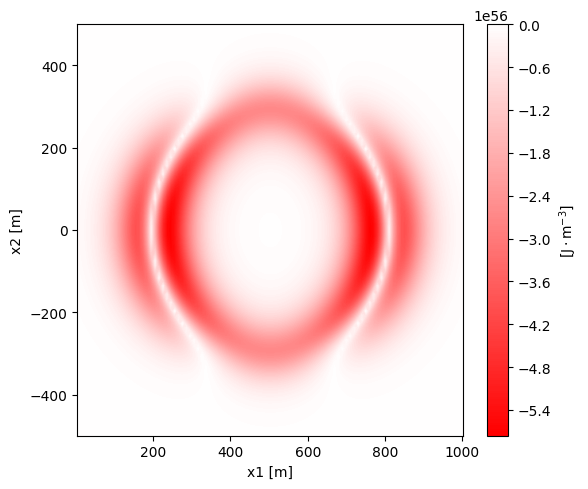

In [11]:
# Define the fixed values
t_val = 1.6778 * 1e-5 * 299792458
z_val=0
# Create a grid for x and y
x_grid = np.linspace(-500, 500, 100) + 503  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 100)
warp_test.display_energy_conditions(space_time_coordinate=[t_val,x_grid,y_grid,z_val],n_grid=8)

In [12]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
f_sympy = sp.expand(warp_test.NEC.subs(f_subs)).doit()
print(f_sympy.free_symbols)

In [ ]:
f_sympy = sp.expand(warp_test.WEC.subs(f_subs)).doit()
print(f_sympy.free_symbols)

In [ ]:
f_sympy = sp.expand(warp_test.SEC.subs(f_subs)).doit()
print(f_sympy.free_symbols)

In [ ]:
f_sympy = sp.expand(warp_test.DEC_intern.subs(f_subs)).doit()
print(f_sympy.free_symbols)

In [ ]:
# Define the fixed values
t_val = 1.6778 * 1e-5 * 299792458

# Create a grid for x and y
x_grid = np.linspace(-300, 300, 15) + 503  # Adjust the range and resolution as needed
y_grid = np.linspace(-300, 300, 15)
z_grid = np.linspace(-300, 300, 15)
warp_test.display_momentum_vector_field_3D(space_time_coordinate=[t_val,x_grid,y_grid,z_grid])

In [ ]:
# Define the fixed values
t_val = 1.6778 * 1e-5 * 299792458
z_val=0
# Create a grid for x and y
x_grid = np.linspace(-400, 400, 50) + 503  # Adjust the range and resolution as needed
y_grid = np.linspace(-400, 400, 50)
warp_test.display_momentum_vector_field_2D(space_time_coordinate=[t_val,x_grid,y_grid,z_val])

In [ ]:
# Define the fixed values
t_val = 1.6778 * 1e-5 * 299792458
z_val = 0

# Create a grid for x and y
x_grid = np.linspace(-500, 500, 100) + 503  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 100)
warp_test.display_metric_scalar(warp_test.expansion_scalar,space_time_coordinate=[t_val,x_grid,y_grid,z_val],title="Expansion scalar")

In [ ]:
# Define the fixed values
t_val = 1.6778 * 1e-5 * 299792458
z_val = 0

# Create a grid for x and y
x_grid = np.linspace(-500, 500, 100) + 503  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 100)
warp_test.display_metric_scalar(warp_test.shear_scalar,space_time_coordinate=[t_val,x_grid,y_grid,z_val],title="Shear scalar")

In [ ]:
# Define the fixed values
t_val = 1.6778 * 1e-5 * 299792458
z_val = 0

# Create a grid for x and y
x_grid = np.linspace(-500, 500, 100) + 503  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 100)
warp_test.display_metric_scalar(warp_test.K,space_time_coordinate=[t_val,x_grid,y_grid,z_val],title="Extrinsic curvature scalar")

In [ ]:
# Define the fixed values
t_val = 1.6778 * 1e-5 * 299792458
z_val = 0

# Create a grid for x and y
x_grid = np.linspace(-500, 500, 100) + 503  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 100)
warp_test.display_energy_momentum_tensor_for_local_oberver(space_time_coordinate=[t_val,x_grid,y_grid,z_val])

In [ ]:
# Define the fixed values
t_val = 1.6778 * 1e-5 * 299792458
z_val = 0

# Create a grid for x and y
x_grid = np.linspace(-500, 500, 100) + 503  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 100)
warp_test.display_energy_momentum_tensor_for_distant_oberver(space_time_coordinate=[t_val,x_grid,y_grid,z_val])

In [ ]:
# Define the fixed values
t_val = 1.6778 * 1e-5 * 299792458
z_val = 0

# Create a grid for x and y
x_grid = np.linspace(-500, 500, 100) + 503  # Adjust the range and resolution as needed
y_grid = np.linspace(-500, 500, 100)
warp_test.display_31_metric(space_time_coordinate=[t_val,x_grid,y_grid,z_val])

In [ ]:
STOP

### Test

In [ ]:
#Numerical Evaluation


#to display

#beta1,2,3 [unit = 1]
#gamma matrix [unit = 1]
#alpha [unit = 1]
#T^^ for n0 (conversion needed) [unit = J m^-3]
#T^^ for minimum values among all observer (conversion needed) [unit = J m^-3]
#stress scalar (might be the same as expansion scalar) [unit = J m^-3]
#shear scalar [unit = m^-1]
#vorticity scalar [unit = m^-1]
#K scalar [unit = m^-1]
#Momentum flow (conversion needed with extra /c to go back to momentum)  [unit = kg m s^-1 m^-3]
#expansion scalar [unit = m^-1]
#NEC (conversion needed) [unit = J m^-3]
#WEC (conversion needed) [unit = J m^-3]
#SEC (conversion needed) [unit = J m^-3]
#DEC (conversion needed) [unit = J m^-3]





#additional notes:
#   time must be given in distance (thus multiply by c).
#   R = 1/m^2
#   g=1
#   Tuv = c^4/8piG = J/m^3
    


In [ ]:
# Constants
c = 299792458  # Speed of light in m/s
G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
vs = 0.1 * c  # Warp speed as a fraction of the speed of light
R = 300  # Warp bubble radius in meters
sigma = 0.015  # Shape function parameter

# Define the shape function f
def f(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    return (np.tanh(sigma * (r+R))-np.tanh(sigma * (r-R))) / (2*np.tanh(sigma*R))

# Create a grid of x and y values
x = np.linspace(-500, 500, 1000)
y = np.linspace(-500, 500, 1000)
X, Y = np.meshgrid(x, y)

# Compute the partial derivatives of f with respect to x and y
dz=0.00001
dy=0.00001
df_dz = (f(X,Y,dz)-f(X,Y,0))/dz
df_dy = (f(X,Y+dy,0)-f(X,Y,0))/dy

# Energy density expression
v = 0.1  # Assume velocity v = 1 for simplicity
energy_density = -v**2 / (4 ) * ((df_dz)**2 + (df_dy)**2)*physical_energy_conversion

# Plotting the energy density
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, energy_density, levels=100, cmap='viridis')
plt.colorbar(label='Energy Density')
plt.title('Energy Density of Alcubierre Warp Drive Metric')
plt.xlabel('x')
plt.ylabel('y')
plt.show()